In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import scipy.io as scio
#warning
import warnings
warnings.filterwarnings('ignore')

d:\Miniconda3\envs\guteEnv\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### GranD Data

In [2]:
##############################################################################
os.chdir('D:/Xanthos GranD and GRDC Data/GranD/dams-rev01-global-shp/')
grand_reservoir = gpd.read_file('GRanD_dams_v1_1.shp')
# remove : tide walls 
#tide_control = ~(grand_reservoir_all['COMMENTS'] == 'Dam for tide control; connects to North Sea; not an ordinary reservoir')
#grand_reservoir_all_without_tidewalls = grand_reservoir_all[tide_control]
##
#grand_reservoir = grand_reservoir_all_without_tidewalls[['GRAND_ID', 'CAP_MCM', 'CATCH_SKM','LAT_DD','LONG_DD', 'MAIN_USE']]
# Drop reservoirs where storage capacity is not reported
#nores_indx = grand_reservoir_normal["CAP_MCM"] < 0   #missing is -99
#grand_reservoir = grand_reservoir_normal[~nores_indx].reset_index(drop=True)

## Update purpose
pposes_unique = grand_reservoir['MAIN_USE'].unique()
main_ppose = [pposes_unique[0],pposes_unique[5],pposes_unique[6]]
# hydropower
_hp = np.where(grand_reservoir['MAIN_USE'] == main_ppose[0])[0]
grand_reservoir.loc[_hp,'Purpose'] = main_ppose[0]
# Irrigation
_irrg = np.where(grand_reservoir['MAIN_USE'] == main_ppose[1])[0]
grand_reservoir.loc[_irrg,'Purpose'] = main_ppose[1]
# Flood Control
_flood = np.where(grand_reservoir['MAIN_USE'] == main_ppose[2])[0]
grand_reservoir.loc[_flood,'Purpose'] = main_ppose[2]
# Others
_others = np.where(~(grand_reservoir['MAIN_USE'] == main_ppose[0]) &
                    ~(grand_reservoir['MAIN_USE'] == main_ppose[1]) &
                      ~(grand_reservoir['MAIN_USE'] == main_ppose[2]))[0]
grand_reservoir.loc[_others,'Purpose'] = 'Others' 

In [3]:
XX = grand_reservoir[['CAP_MCM']]
XX[XX['CAP_MCM'] > 0].sum() /1e3

CAP_MCM    6197.0741
dtype: float64

### GRDC Stations and Basin Average Demand 

In [4]:
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')
indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)

## Demand
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\figures-v2')
basin_xnths = np.array(pd.read_csv("basin.csv"))
data_demand = scio.loadmat("Total_Water_Demand_mmpermonth_1971_2010.mat")
Basin_demand1 = data_demand["Total_Water_Demand"]
Basin_demand = np.nanmean(Basin_demand1, axis=1)
demand_basinD  = np.ones([len(basins94),1]) * np.nan
for ii in range(len(basins94)):
    basin_dd = basins94[ii]
    indx_basin = np.squeeze(basin_xnths == basin_dd)
    demand_basinD[ii] = np.nanmean(Basin_demand[indx_basin])

GRDC_xanthosCoordIndx['Demand_mmperMonth'] = demand_basinD

### Demand + Basin Polygon

In [5]:
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\flow\\'
file_dir_watch_natr = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-YL\\flow\\'
#basin_235_xanthos = gpd.read_file('D:\\GCAM-Manuscript\\Figurers\\Data Spatial Map\\basin_235_xanthos\\basin_harmed.shp')
basin_235_xanthos = gpd.read_file('D:\\Xanthos-Repo\\basin_harmed\\basin_harmed.shp')
xx = np.zeros([91,])
for ii in range(91):
    basin_num = basins94[ii]    
    #################
    indx_poly = np.where(basin_235_xanthos['GRIDCODE']==basin_num)[0]
    basin_235_xanthos.loc[indx_poly,'DemandMMperMonth'] = GRDC_xanthosCoordIndx['Demand_mmperMonth'][ii]

### Mapping

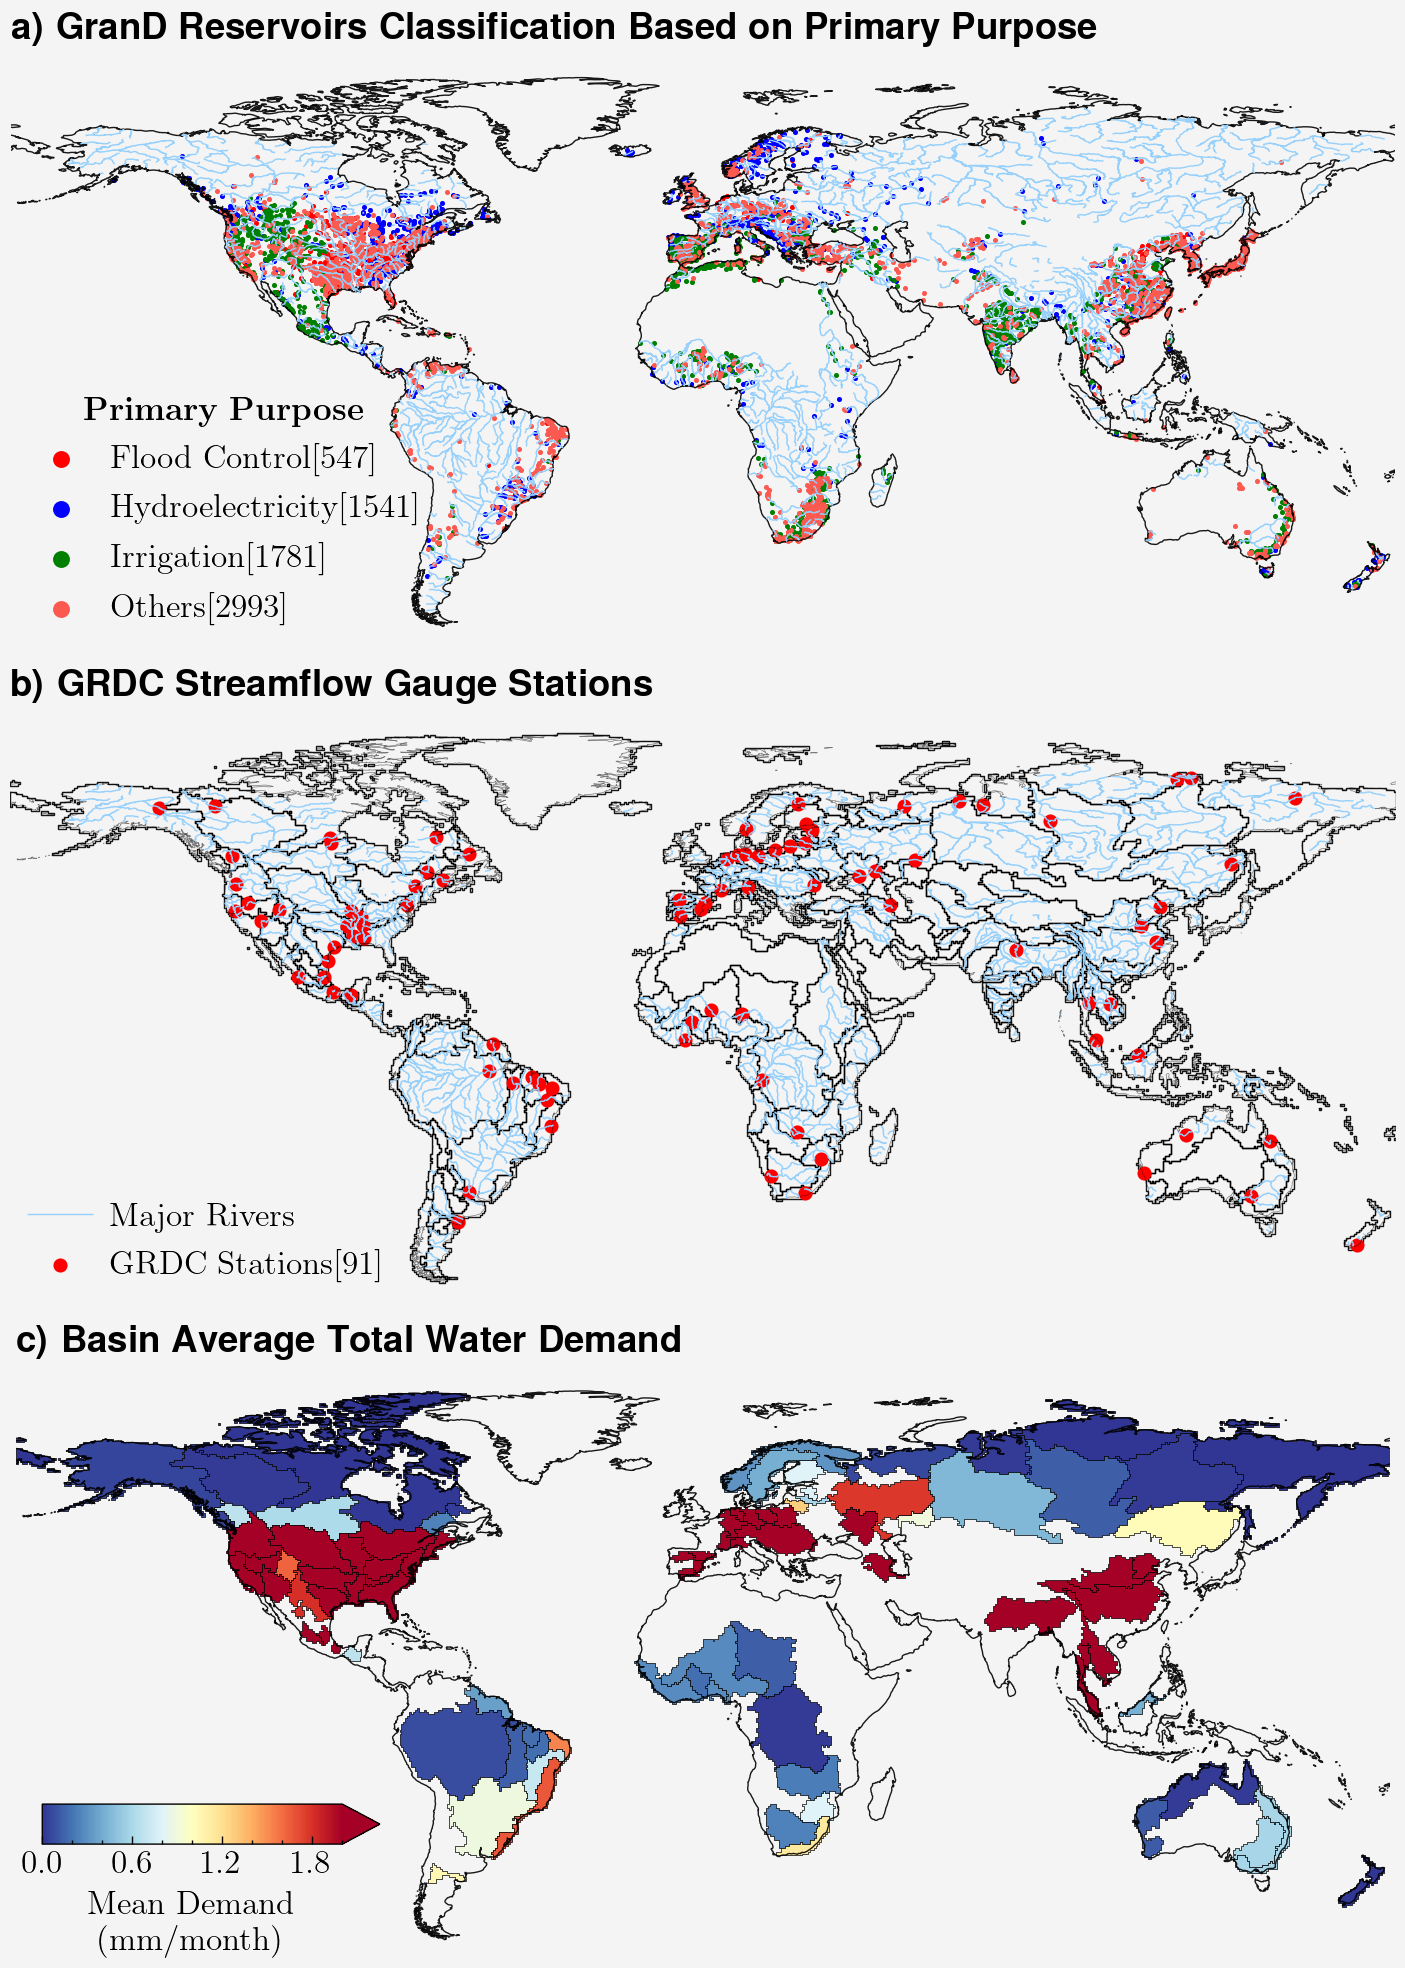

In [6]:
# xarray
import xarray 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt
import geopandas as gpd 

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 

#plt.rcParams["axes.labelweight"] = 'bold'
#plt.rcParams["axes.titleweight"] = 'bold'

CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,"linewidth":0.5}
BASE_PLOT2 = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.5,"linewidth":0.25}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#coastlines
coastlines_path = 'D:\\Xanthos-Repo\\ne_50m_coastline\\ne_50m_coastline.shp'
coastlines = gpd.read_file(coastlines_path)

# rivers
rivers = gpd.read_file('D:\\Xanthos-Repo\\Xanthos-Manuscript\\figures\\codes\\Figure-3\\world_rivers_dSe\\world_rivers_dSe.shp')

N=10
c = np.linspace(-N / 2, N / 2, N + 1)
fig, axes = pplt.subplots(nrows=3, ncols=1, share=0, space = 2, refheight='2.95')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        # GranD
        ax = axes[0]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT)   
        rivers.to_crs(CRS).plot(ax=ax, color='light blue', linewidth=0.5)  
        grand_reservoir.loc[_flood].plot(ax=ax, x='LONG_DD', y='LAT_DD', c='red', markersize=1.5, label = 'Flood Control[' + str(len(_flood)) +']')
        grand_reservoir.loc[_hp].plot(ax=ax, x='LONG_DD', y='LAT_DD', c='blue', markersize=1.5, label = 'Hydroelectricity['+ str(len(_hp)) +']')
        grand_reservoir.loc[_irrg].plot(ax=ax, x='LONG_DD', y='LAT_DD', c='green', markersize=1.5, label = 'Irrigation['+ str(len(_irrg)) +']')
        grand_reservoir.loc[_others].plot(ax=ax, x='LONG_DD', y='LAT_DD', c='coral', markersize=1.5, label = 'Others['+ str(len(_others)) +']')          
        ax.set_axis_off()
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        lgnd = ax.legend(ncol=1, loc='ll', title=r'$\bf{{{Primary\ Purpose}}}$')
        lgnd.legendHandles[0]._sizes = [30]
        lgnd.legendHandles[1]._sizes = [30]
        lgnd.legendHandles[2]._sizes = [30]
        lgnd.legendHandles[3]._sizes = [30]
        ax.format(title=r'$\bf{{{GranD\ Reservoirs\ Classification\ Based\ on\ Primary\ Purpose }}}$', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)

        ## GRDC Sites   
        ax = axes[1]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT2)   
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='GRIDCODE', **BASE_PLOT, label='Xanthos Basins') 
        rivers.to_crs(CRS).plot(ax=ax, color='light blue', linewidth=0.5, label='Major Rivers')  
        ax.scatter(GRDC_xanthosCoordIndx['long'], GRDC_xanthosCoordIndx['lat'], c='red', s=20, label = 'GRDC Stations[' + str(GRDC_xanthosCoordIndx.shape[0]) +']')                                                                             
        ax.set_axis_off()
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])    
        ax.legend(ncol=1, loc='ll')
        ax.format(abc=True , title=r'$\bf{{{GRDC\ Streamflow\ Gauge\ Stations}}}$', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)
        

        ## Demand
        cmap = mpl.cm.RdYlBu_r
        norm = mpl.colors.Normalize(vmin=0, vmax=2.0)
        cm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)


        ax = axes[2]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='DemandMMperMonth', cmap=cmap, legend=False,  
                                               edgecolor='k',linewidth=0.25, vmin=0, vmax=2.0,)
                                               #legend_kwds={"loc":"center right",'shrink':0.65,'width':0.10,
                                               #         'extend':'max', 'ticks':0.4, 'minorticks':0.2, 
                                               #         'label': "Mean Demand (mm/month)",
                                               #        'labelweight':'bold', 'labelsize':12, "pad":-5})                                                                                  

        ax.colorbar(cm, location="ll", ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],length=9,
                     extend = 'max', label= "Mean Demand \n (mm/month)",
                    labelweight='bold', labelsize=12,frameon=False , tickminor=True)
        ax.set_axis_off()
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])     
        ax.format(title=r'$\bf{{{Basin\ Average\ Total\ Water\ Demand}}}$', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)
        #ax.colorbar(f, loc='ll')
        ax.legend(loc='ll')

 
plt.tight_layout()
fig_dir = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\Desktop\\Xanthos-Manuscript\\Manuscript-09072022\\Figures-Updated\\'
plt.savefig(fig_dir + "Figure-3-SpatialMap-GranD-GRDC-Demand.png", **SAVE_KWDS)   

SyntaxError: keyword argument repeated: length (1493098636.py, line 21)

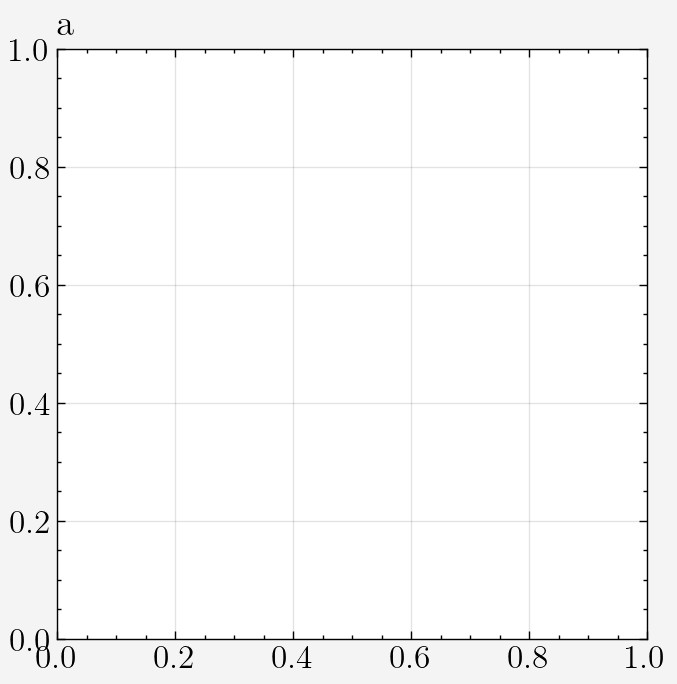

In [7]:
fig, axes = pplt.subplots(nrows=1, ncols=1, share=0, space = 2, refheight='2.95')
cmap = mpl.cm.RdYlBu_r
norm = mpl.colors.Normalize(vmin=0, vmax=2.0)
cm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        ## Demand
        ax = axes
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        f = basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='DemandMMperMonth', legend=False,  cmap=cmap, 
                                               edgecolor='k',linewidth=0.25, vmin=0, vmax=2.0)  





        ax.colorbar(cm, loc="ll", ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],length=10, 
                    length=8,  label= "Mean Demand (mm/month)",extend='max',
                    labelweight='bold', labelsize=12 , tickminor=True,)
 
        
        ax.set_axis_off()
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])  
       



In [ ]:
[0.0, 0.4, 0.8, 1.2, 1.6, 2.0]